In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.models import model_from_json

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Load data

In [2]:
X_raw = np.load("data/images.npy")
y = np.load("data/labels.npy")
y = [val[0] for val in y]

In [6]:
print(f"Images are {X_raw[0].shape[0]} x {X_raw[0].shape[1]} pixels with {X_raw[0].shape[2]} color channels")

Images are 480 x 640 pixels with 3 color channels


# VGG16 importing and fine tuning

Images are 224 x 224 pixels with 3 color channels
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


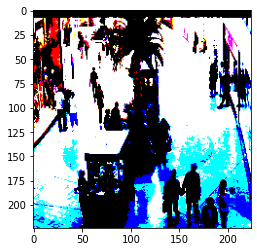

In [7]:
# prepare images for the VGG model
X = []
for i in range(len(X_raw)):
    X.append(cv2.resize(X_raw[i],(112*2,112*2),3))
    X[i] = preprocess_input(X[i])

print(f"Images are {X[0].shape[0]} x {X[0].shape[1]} pixels with {X[0].shape[2]} color channels")
plt.imshow(X[0]) 

In [8]:
# setting features and target value
from sklearn.model_selection import train_test_split

X = np.asarray(X)
y = np.asarray(y)

# train test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1)

# validation split
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

## Model VGG16 fine tuning (on kaggle, don't run here!)

In [ ]:
# Import VGG16
vgg16_model = VGG16(weights='../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    input_shape=(112*2,112*2,3) ,include_top=False, pooling=False)

# Final part of network
x = vgg16_model.output  # Output is of the pooling layer
x = Dropout(0.3)(x)
x = Flatten()(x)
#x = Dense(128, activation='relu')(x)  # Fully-connected layer because ends with maxpooling
predictions = Dense(1)(x)  # New output layer / regressor

# Create final model
vgg16_model_total = Model(inputs=vgg16_model.input, outputs=predictions)
vgg16_model_total.summary()

In [ ]:
for l in vgg16_model_total.layers[:-3]:
    l.trainable = False # train only final part of network

for l in vgg16_model_total.layers:
    print(l.name, l.trainable)

In [ ]:
# Compile the model
vgg16_model_total.compile(loss="mean_squared_error",
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                          metrics=['mae'])

In [ ]:
history = vgg16_model_total.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=20, batch_size=32)


In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.epoch,history.history['loss'], label='train loss')
    plt.plot(history.epoch,history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.grid(True)
    plt.show()
plot_learning_curves(history)

In [ ]:
# serialize model to JSON
model_save_json = vgg16_model_total.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_save_json)

# serialize weights to HDF5
vgg16_model_total.save_weights("vgg16_model_total.h5")
print("Saved model to disk")

## Load model trained on Kaggle

In [11]:
# load json and create model
json_file = open('trained_models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("trained_models/vgg16_model_total.h5")
print("Loaded model from disk")

Loaded model from disk


In [12]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
loaded_model.compile(loss='mean_squared_error', 
                     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), 
                     metrics=['mae'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)

In [24]:
print(f'On test set we have a mean absolute error of {round(score[1],2)} people')

On test set we have a mean absolute error of 2.35 people


In [28]:
# predict test set

predictions = loaded_model.predict(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


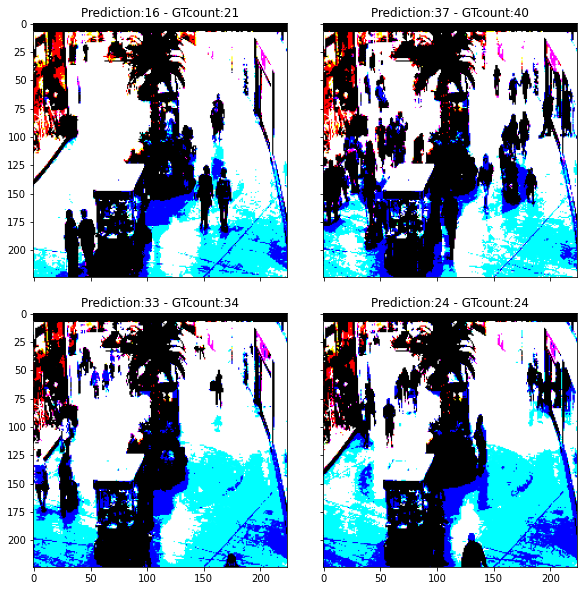

In [37]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(
        fig, 111,
        nrows_ncols=(2,2),
        axes_pad=0.5)

for i in range(0,4):
    grid[i].set_title('Prediction:'+ str(int(np.round(predictions[i],1))) +' - GTcount:'+str(y_test[i]))
    grid[i].imshow(X_test[i])